<a href="https://colab.research.google.com/github/thabsburg/dotfiles/blob/master/Deep_Learning_and_Machine_Learning_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Import Libraries

In [ ]:
# If needed
!pip install pmdarima

In [ ]:
# First we will import the necessary Library
import yfinance as yf
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
from scipy.stats import norm

# For model building we will use these library
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, ElasticNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# For model tuning
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

# For evalution we will use these library
from sklearn.metrics import (
    mean_squared_error, mean_absolute_percentage_error, explained_variance_score,
    r2_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score,precision_score,
    recall_score, f1_score, roc_auc_score, make_scorer
)

# For ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.model_selection import TimeSeriesSplit

# For plotting we will use these library
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

## Load Dataset

In [ ]:
# Load our dataset 
# Datset to be found in the Datafile on Github
data = pd.read_csv(
    'BTC-USD.csv'
)
data.drop(columns=['Adj Close'], inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


## Data exploration

### Basics

In [ ]:
print(
    '### NAs ###\n',
    data.isna().sum(), '\n',
    '### start_date and end_date ###\n',
    data['Date'].min(), data['Date'].max(), '\n',
    )

### NAs ###
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64 
 ### start_date and end_date ###
 2014-09-17 00:00:00 2023-02-01 00:00:00 



### Advanced

In [ ]:
# Separate per month
monthwise= data.groupby(data['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)

# Plot a barchart of entire dataset
names = cycle(
    ['Bitcoin Open Price','Bitcoin Close Price','Bitcoin High Price','Bitcoin Low Price']
)

fig = px.line(
    data, x=data.Date, y=[data['Open'], data['Close'], data['High'], data['Low']],
    labels={'Date': 'Date','value':'Bitcoin value'}
)
fig.update_layout(
    title_text='Available BTC data ', font_size=15, font_color='black',
    legend_title_text='Bitcoin Parameters'
)
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
# Create dataframe with only closing price
target_df = data[data['Date'] >= '2021-02-21']
print('Considered data points:', target_df.shape[0])

# Plot just the last year
fig = px.line(
    target_df, x=target_df['Date'], y=target_df['Close'],
    labels={'date':'Date','close':'Close Stock'}
)
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(
    title_text='Considered dataset of BTC Close', 
    plot_bgcolor='white', font_size=15, font_color='black'
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Considered data points: 711


# Feature Engineering

## Moving average(s)

In [ ]:
lags = [10, 20, 50, 100, 200]
cols_considered = ['Open', 'High', 'Low', 'Close', 'Volume']

for col in cols_considered:
  for lag in lags:
    data[f'{col}_MA_{lag}'] = data[col].rolling(window=lag).mean()

## Days range
I don't know what this does. Please explain

In [ ]:
for lag in lags:
  data[
      f'{lag}_daysRange'
  ] = data['High'].rolling(window=lag).max() - data['High'].rolling(window=lag).min()

## Days up and down

In [ ]:
# Price increase on next day
data['growth'] = 0
# growth is set to 1 if price is lower?
data.loc[data['Close'] > data['Close'].shift(1), 'growth'] = 1

# How many days has stock been growing?
data['num_consec_days_up'] = data['growth'].groupby(
    (data['growth'] != data['growth'].shift()
  ).cumsum()).cumcount()
# Add one day
data['num_consec_days_up'] += 1
# Days up is zero if price is not up on next day
data.loc[data['growth'] == 0, 'num_consec_days_up'] = 0

# How many days has stock been falling?
data['num_consec_days_down'] = data['growth'].groupby(
    (data['growth'] != data['growth'].shift()
  ).cumsum()).cumcount()
data['num_consec_days_down'] += 1
data.loc[data['growth'] == 1, 'num_consec_days_down'] = 0
data.drop(columns='growth', inplace=True)

## Value-at-risk (VaR)
VaR measures the potential loss of an investment or portfolio over a given time period, with a certain level of confidence.[link text](https://)

In [ ]:
def var_cov_var(P, c, mu, sigma):
    """
    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns mu
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = norm.ppf(1-c, mu, sigma)
    return P - P * (alpha + 1)

In [ ]:
# Set up variables for VaR
# TODO what is rets?
data["rets"] = data["Close"].pct_change()
data["rets_mean"] = data["rets"].rolling(window=10).mean()
data["rets_sigma"] = data["rets"].rolling(window=10).std()

P = 1000   # 1,000 USD
c = 0.99  # 99% confidence interval
data["VaR"] = np.vectorize(var_cov_var)(
    P, c, data["rets_mean"], data["rets_sigma"]
)

# Drop 'helper' columns
helper_columns = ['rets', 'rets_mean', 'rets_sigma']

## Relative strength index (RSI)
RSI is a technical indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in an asset

In [ ]:
def RSI(prices, n=9):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    down = -seed[seed<0].sum()/n
    up = seed[seed>=0].sum()/n   
    rs = up/down
    rsi = np.zeros(len(prices))
    rsi[:n] = 100- 100/(1+rs)
    for i in range(n,len(prices)):
        delta = deltas[i-1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta

        up = float((up*(n-1)+upval)/n)
        down = float((down*(n-1)+downval)/n+0.00001)
        rs = up/down
        rsi[i] = 100 - 100/(1+rs)
    return rsi

In [ ]:
# Calculate RSI for different periods
periods = [5, 9, 14, 18]
for period in periods:
    data[f'rsi_{str(period)}'] = RSI(data['Close'], period)

# Preparing final dataset

## Target: next_day_up
Calculates whether the Closing price will increase or decrease the next day

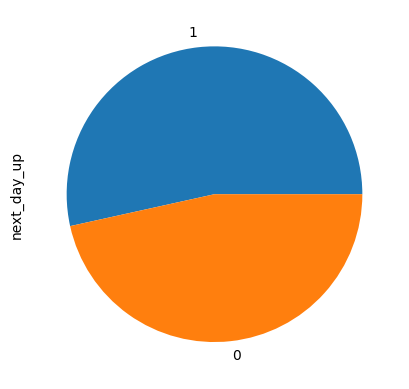

In [ ]:
data['next_day_up'] = (data['Close'] < data['Close'].shift(-1)).astype(int)
# Plot
data['next_day_up'].value_counts().plot(kind='pie')
plt.show()

## Cropping

In [ ]:
# Define observation timeframe
start_date = '2016-02-21'
end_date = '2023-02-01'

data_final = data.loc[
    (data['Date'] >= start_date) &
    (data['Date'] <= end_date)
]

print('Total observations:', len(data_final))
# Check if all data available
print('Null values:', np.any(data_final.isnull().sum() > 0))

Total observations: 2538
Null values: False


## Feature selection

### Corelation analysis

<ipython-input-45-79c1bdee4248>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



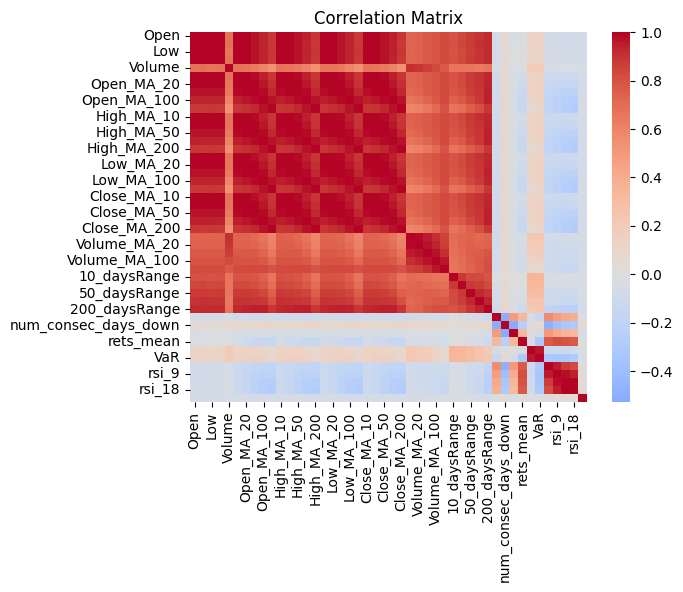

In [ ]:
# Define and plot correlation matrix
corr_matrix = data_final.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Matrix')
plt.show()

### RandomForrestClassifier for feature selection

In [ ]:
# Select X and y variable(s)
X_prelim = data_final.drop(columns=['Date', 'next_day_up'])
y = data_final['next_day_up'].values

In [ ]:
# fit a random forest model and ex_prelimtract feature importances
rf = RandomForestClassifier(
    n_estimators=200, max_features='sqrt', min_samples_split=2, min_samples_leaf=1, random_state=42
)
rf.fit(StandardScaler().fit_transform(X_prelim), y)
importances = rf.feature_importances_

# sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# print the feature ranking
print("Feature ranking:")
for f in range(X_prelim.shape[1]):
  print(
      f'{f+1}. feature {indices[f]}: {data.iloc[:, indices[f]+1].name} {importances[indices[f]]}'
  )

# select the most important features based on threshold
# threshold = 10 # select top n features
# selected_features = indices[:threshold]

# or manually select features based on importance
selected_features = [
    37, # rets
    41, # rsi_5
    4, # Volume
    40, # VaR
    30, # 10_daysRange
    3, # Close
    29, # Volume_MA_200
    14, # High_MA_200
    35, # num_consecutive_days_up
    33, # 100_daysRange
    36, # num_consecutive_days_down
]
X = X_prelim.iloc[:, selected_features]
print(
    '\n--------',
    '\nall features shape:', X_prelim.shape,
    '\nselected features shape:', X.shape
)

Feature ranking:
1. feature 37: rets 0.04082166102355301
2. feature 41: rsi_5 0.037296041565314936
3. feature 38: rets_mean 0.03555704779767803
4. feature 42: rsi_9 0.03443794894694182
5. feature 44: rsi_18 0.033301975876122256
6. feature 40: VaR 0.03316979092789287
7. feature 43: rsi_14 0.032847851815175355
8. feature 4: Volume 0.03125230988011178
9. feature 39: rets_sigma 0.03105825069156114
10. feature 25: Volume_MA_10 0.029252459240258086
11. feature 30: 10_daysRange 0.026720118151306992
12. feature 3: Close 0.024862911174780917
13. feature 26: Volume_MA_20 0.02485646027086198
14. feature 27: Volume_MA_50 0.02425455724530491
15. feature 29: Volume_MA_200 0.023449708085964024
16. feature 2: Low 0.023382213372640327
17. feature 0: Open 0.023161299636368503
18. feature 28: Volume_MA_100 0.0227963197962472
19. feature 31: 20_daysRange 0.021898237189230625
20. feature 1: High 0.02165428004589288
21. feature 32: 50_daysRange 0.01905498833809606
22. feature 24: Close_MA_200 0.018835789139

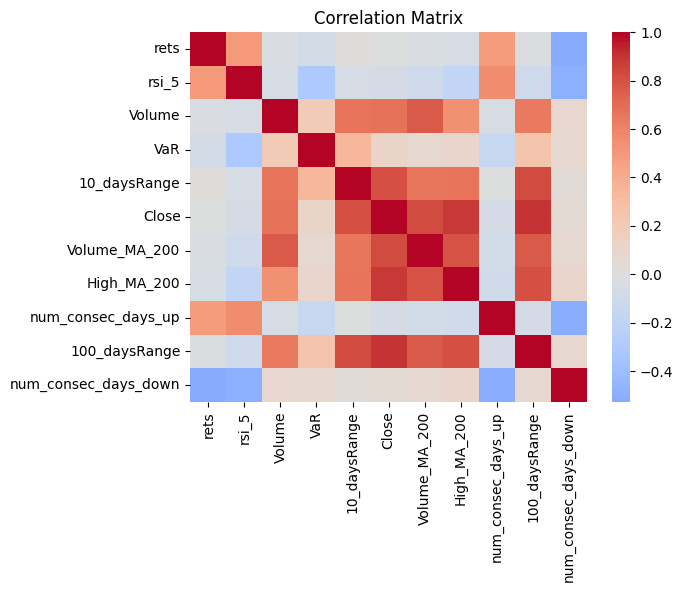

In [ ]:
# Define and plot correlation matrix
corr_matrix = X.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Matrix')
plt.show()

## Scaling & train test split

In [ ]:
test_size = 0.3
val_size = 0.2

In [ ]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, # features selected by performance
    # X_prelim, # all features
    y,
    test_size=test_size, shuffle=True
)

# Separate train set further into validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, # features selected by performance
    # X_prelim, # all features
    y,
    test_size=val_size, shuffle=True
)

# Fit scaler on training data
# TODO implement in pipeline
# scaler = StandardScaler()
scaler = MinMaxScaler()
# NOTE fit on training data only otherwise data leakage
scaler.fit(X_train)
# Transfrom test and train data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Model

## Regression models

### Lasso
* **Alpha (λ)**: Alpha controls the amount of regularization applied to the model. Higher values of alpha lead to more shrinkage of the coefficients towards zero, resulting in a simpler model with less variance and higher bias.
* **Maximum iterations**: This parameter sets the maximum number of iterations that the algorithm will run before stopping. If the algorithm hasn't converged to a solution after this number of iterations, it will stop and return the best solution found.

In [ ]:
# Define binary classification function
def binary_classification_accuracy(y_true, y_pred):
    y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]
    return accuracy_score(y_true, y_pred_binary)

# Create scorer using the binary classification function
scorer = make_scorer(binary_classification_accuracy)

In [ ]:
# Initiate model
lasso = Lasso()
# Set grid for hyperparameter tuning
params = {
    'alpha': [0.005, 0.01, 0.015],
    'max_iter': [16, 32, 64]
}
# Set up and fit grid search
grid_search = GridSearchCV(estimator=lasso, param_grid=params, scoring=scorer)
grid_search.fit(X_train_scaled, y_train)
# Define best parameters
best_params = grid_search.best_params_
print(best_params)

# Set up model with best parameters
lasso_best = Lasso(alpha=best_params['alpha'], max_iter=best_params['max_iter'])
lasso_best.fit(X_train_scaled, y_train)
# Predict test set
y_pred = lasso_best.predict(X_test_scaled)
# Make output binary
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]
# Test accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}%".format(accuracy * 100))

{'alpha': 0.01, 'max_iter': 16}
Accuracy: 54.86%


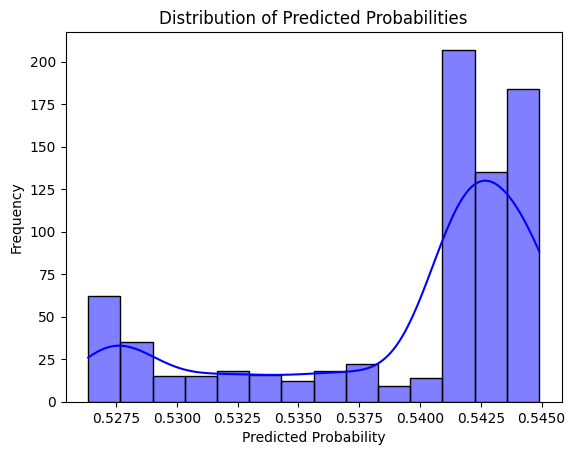

In [ ]:
# This shows that the model cannot predict the outcome confidently (near .5)
sns.histplot(y_pred, kde=True, color='blue', alpha=0.5)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

### ElasticNet
(For documentation, please Lasso above)
* **Alpha (λ)**: Alpha controls the balance between the L1 and L2 regularization. L1 regularization promotes sparsity by setting some coefficients to zero, while L2 regularization promotes smoothness by reducing the magnitude of all coefficients.
* **L1 ratio (ρ)**: The L1 ratio controls the relative weight of L1 and L2 regularization. A value of 1 corresponds to pure L1 regularization, while a value of 0 corresponds to pure L2 regularization.

In [ ]:
elastic_net = ElasticNet()
params = {
     'alpha': [0.01, 0.1, 1],
     'l1_ratio': [0.2, 0.5, 0.8]
}
grid_search = GridSearchCV(estimator=elastic_net, param_grid=params, scoring=scorer)
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print(best_params)

elastic_net_best = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'])
elastic_net_best.fit(X_train_scaled, y_train)
y_pred = elastic_net_best.predict(X_test_scaled)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}%".format(accuracy * 100))

{'alpha': 0.1, 'l1_ratio': 0.2}
Accuracy: 54.86%


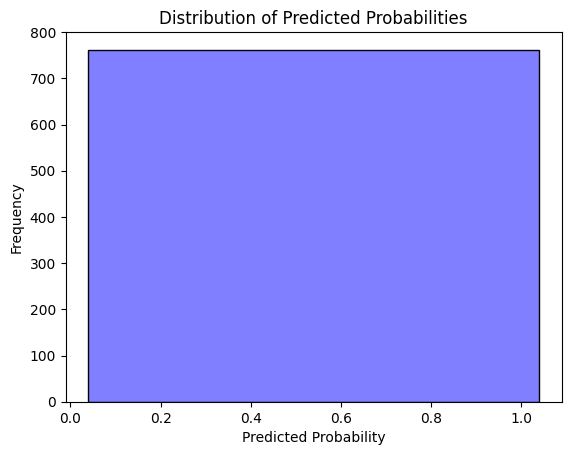

In [ ]:
# The model only predicts one value
sns.histplot(y_pred, kde=True, color='blue', alpha=0.5)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

## Basic neural network
* best optimizer: adam (mean accuracy in sample of 5: {'**adam**': 0.5308411121368408, 'rmsprop': 0.5112149357795716, 'sgd': 0.5121495425701141})
* best lr: {0.001: 0.5317756950855255, 0.01: 0.5196261763572693, 0.1: 0.5140186905860901}
* best loss function: {'**binary_crossentropy**': 0.5280373811721801, 'hinge': 0.5177570044994354, 'squared_hinge': 0.5233644843101501}
* best batch size: {16: 0.5271027982234955, **32**: 0.5299065291881562, 64: 0.5028037309646607, 128: 0.5074766337871551}


In [ ]:
# Design the model
sequential = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2), # dropout of 20%
    Dense(32, activation='tanh'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
sequential.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit model with EarlyStopping (stops before overfitting)
es = EarlyStopping(restore_best_weights=True)
sequential.fit(
    X_train_scaled, y_train,
    batch_size=32, # between 16 and 32 for real-world data (max 32)
    epochs=1000, # Don't matter because of es
    validation_data=(X_val_scaled, y_val), # to prevent overfitting
    shuffle=True, # to prevent model memorizing training data
    callbacks=[es], # to prevent overfitting
    verbose=0,
)

# Evaluate the model on the test data
metrics = sequential.evaluate(X_test_scaled, y_test)
# Print the metrics
print("Accuracy: {:.2f}%".format(metrics[1] * 100))

24/24 [==============================] - 0s 2ms/step - loss: 0.6879 - accuracy: 0.5486
Accuracy: 54.86%


24/24 [==============================] - 0s 1ms/step


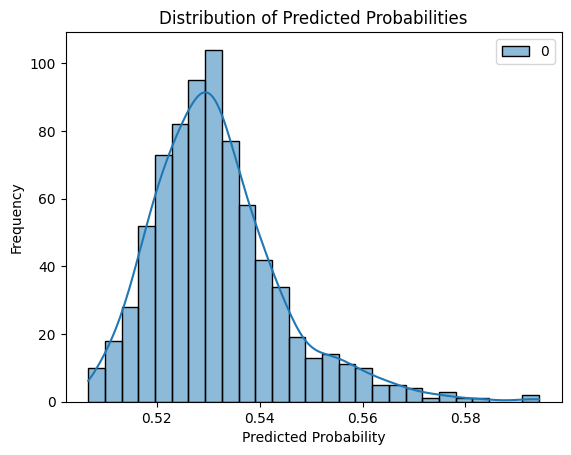

In [ ]:
y_pred = sequential.predict(X_test_scaled)
# This shows that the model is rather unconfident with its predictions
sns.histplot(y_pred, kde=True, color='blue', alpha=0.5)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

## Recurrent neural network (RNN)

#### Data preparation
* Data should not be shuffled
* 2D data has to be transformed into 3D shape

In [ ]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, # features selected by performance
    # X_prelim, # all features
    y,
    test_size=test_size, shuffle=False
)

# Separate train set further into validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, # features selected by performance
    # X_prelim, # all features
    y,
    test_size=val_size, shuffle=False
)

# Fit scaler on training data
# TODO implement in pipeline
# scaler = StandardScaler()
scaler = MinMaxScaler()
# NOTE fit on training data only otherwise data leakage
scaler.fit(X_train)
# Transfrom test and train data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Create sequences
sequence_length = 50

### Train data ###
X_train_sequences = []
y_train_sequences = []
for i in range(len(X_train_scaled) - sequence_length):
    X_train_sequences.append(X_train_scaled[i:i+sequence_length])
    y_train_sequences.append(y_train[i+sequence_length])
X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)
# Reshape data
X_train_reshaped = np.reshape(X_train_sequences, (X_train_sequences.shape[0], sequence_length, X_train_sequences.shape[2]))
y_train_reshaped = y_train_sequences.reshape(y_train_sequences.shape[0], 1)

### Validation data ###
X_val_sequences = []
y_val_sequences = []
for i in range(len(X_val_scaled) - sequence_length):
    X_val_sequences.append(X_val_scaled[i:i+sequence_length])
    y_val_sequences.append(y_val[i+sequence_length])
X_val_sequences = np.array(X_val_sequences)
y_val_sequences = np.array(y_val_sequences)
# Reshape data
X_val_reshaped = np.reshape(X_val_sequences, (X_val_sequences.shape[0], sequence_length, X_val_sequences.shape[2]))
y_val_reshaped = y_val_sequences.reshape(y_val_sequences.shape[0], 1)

### Test data ###
X_test_sequences = []
y_test_sequences = []
for i in range(len(X_test_scaled) - sequence_length):
    X_test_sequences.append(X_test_scaled[i:i+sequence_length])
    y_test_sequences.append(y_test[i+sequence_length])
X_test_sequences = np.array(X_test_sequences)
y_test_sequences = np.array(y_test_sequences)
# Reshape data
X_test_reshaped = np.reshape(X_test_sequences, (X_test_sequences.shape[0], sequence_length, X_test_sequences.shape[2]))
y_test_reshaped = y_test_sequences.reshape(y_test_sequences.shape[0], 1)


In [ ]:
print(
    'train', X_train_reshaped.shape, y_train_reshaped.shape,
    '\nval', X_val_reshaped.shape, y_val_reshaped.shape,
    '\ntest', X_test_reshaped.shape, y_test_reshaped.shape,
)

train (1980, 50, 11) (1980, 1) 
val (458, 50, 11) (458, 1) 
test (712, 50, 11) (712, 1)


### LSTM

#### General architecture

**Architecture testing**
* LSTM(64,do), LSTM(32, do), Dense(16, relu): NA
* LSTM (64, do), Dense(16, relu): **0.5**
* LSTM (64, do), Dense(32, relu): 0.4970350444316864
* LSTM (64, do), Dense(8, relu): 0.4973045766353607



In [ ]:
iterations = 5
performance = []
for _ in range(iterations):
  rnn_lstm = Sequential([
      LSTM(64, return_sequences=False, input_shape=X_train_reshaped.shape[1:]),
      Dropout(0.2), # dropout of 20%
      # LSTM(32, return_sequences=False),
      # Dropout(0.2), # dropout of 20%
      Dense(16, activation='relu'),
      BatchNormalization(),
      Dense(1, activation='sigmoid')
  ])

  # Compile the model
  rnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Fit model with EarlyStopping (stops before overfitting)
  es = EarlyStopping(restore_best_weights=True)
  rnn_lstm.fit(
      X_train_reshaped, y_train_reshaped,
      batch_size=64,
      epochs=1000, # Don't matter because of es
      validation_data=(X_val_reshaped, y_val_reshaped), # to prevent overfitting
      callbacks=[es], # to prevent overfitting
      shuffle=True,
      verbose=0
  )

  # Evaluate the model on the test data
  metrics = rnn_lstm.evaluate(X_test_reshaped, y_test_reshaped)
  # Print the metrics
  print("Accuracy: {:.4f}%".format(metrics[1] * 100))
  performance.append(metrics[1])
print(sum(performance)/iterations)

23/23 [==============================] - 0s 10ms/step - loss: 0.6929 - accuracy: 0.5028
Accuracy: 50.2809%
23/23 [==============================] - 0s 13ms/step - loss: 0.6946 - accuracy: 0.4916
Accuracy: 49.1573%
23/23 [==============================] - 0s 14ms/step - loss: 0.6929 - accuracy: 0.5084
Accuracy: 50.8427%
23/23 [==============================] - 0s 10ms/step - loss: 0.6939 - accuracy: 0.5084
Accuracy: 50.8427%
23/23 [==============================] - 0s 10ms/step - loss: 0.6967 - accuracy: 0.4916
Accuracy: 49.1573%
0.500561797618866


23/23 [==============================] - 1s 11ms/step


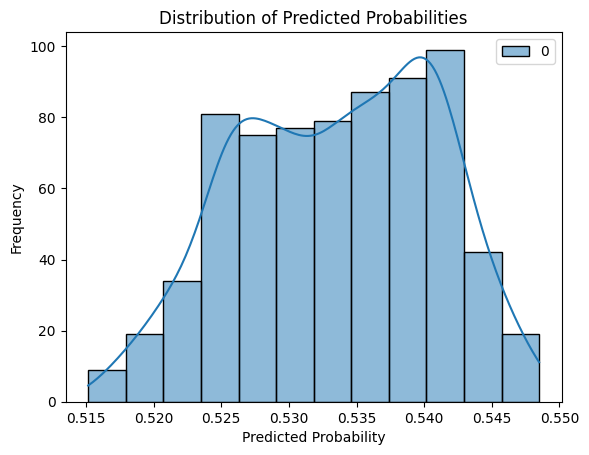

In [ ]:
y_pred = rnn_lstm.predict(X_test_reshaped)
# This shows that the model is rather unconfident with its predictions
sns.histplot(y_pred, kde=True, color='blue', alpha=0.5)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

#### Hyperparameter tuning
Best parameters:  {'learning_rate': 0.001, 'loss': 'binary_crossentropy', 'optimizer': 'adam'}
Best accuracy: 55.6061%

In [ ]:
def create_model(loss='binary_crossentropy', optimizer='adam', learning_rate=0.001):
  # Set up model infrastructure
  model = Sequential([
      LSTM(64, return_sequences=False, input_shape=X_train_reshaped.shape[1:]),
      Dropout(0.2), # dropout of 20%
      Dense(16, activation='relu'),
      BatchNormalization(),
      Dense(1, activation='sigmoid')
  ])

  # Set up model compilation with different optimizers
  if optimizer == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
  elif optimizer == ' rmsprop':
    optimizer == RMSprop(learning_rate=learning_rate)
  elif optimizer == 'sgd':
    optimizer == SGD(learning_rate=learning_rate)
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

  return model

# create a KerasClassifier with the LSTM model
model_creator = KerasClassifier(build_fn=create_model, verbose=0)

# define the hyperparameters to tune
param_grid = {
    'loss': ['binary_crossentropy', 'hinge', 'squared_hinge'],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'learning_rate': [0.001, 0.01, 0.1]
}

# create a GridSearchCV object with the KerasClassifier and the hyperparameters to tune
grid_search = GridSearchCV(
    estimator=model_creator, param_grid=param_grid, scoring='accuracy',
    n_jobs=-1
)

es = EarlyStopping(restore_best_weights=True)
grid_result = grid_search.fit(
    X_train_reshaped, y_train_reshaped,
    batch_size=64,
    epochs=1000, # Don't matter because of es
    validation_data=(X_val_reshaped, y_val_reshaped), # to prevent overfitting
    callbacks=[es], # to prevent overfitting
    shuffle=True,
    verbose=1
)

# print the best hyperparameters and the corresponding accuracy
print("Best parameters: ", grid_result.best_params_)
print("Best accuracy: {:.4f}%".format(grid_result.best_score_ * 100))

# Set final tuned model
tuned_lstm = grid_result.best_estimator_

<ipython-input-321-3e66bfb9df8b>:23: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Epoch 1/1000
31/31 [==============================] - 5s 66ms/step - loss: 0.7456 - accuracy: 0.4899 - val_loss: 0.6922 - val_accuracy: 0.5197
Epoch 2/1000
31/31 [==============================] - 1s 42ms/step - loss: 0.7108 - accuracy: 0.5197 - val_loss: 0.6925 - val_accuracy: 0.5240
Best parameters:  {'learning_rate': 0.001, 'loss': 'binary_crossentropy', 'optimizer': 'adam'}
Best accuracy: 55.6061%


#### Final model backup
Filling in optimized paramters into static model as a backup due to KerasClassifier limited usability (DeprecationWarning)

In [ ]:
tuned_lstm_backup = Sequential([
    LSTM(64, return_sequences=False, input_shape=X_train_reshaped.shape[1:]),
    Dropout(0.2), # dropout of 20%
    # LSTM(32, return_sequences=False),
    # Dropout(0.2), # dropout of 20%
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(0.001)
tuned_lstm_backup.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit model with EarlyStopping (stops before overfitting)
es = EarlyStopping(restore_best_weights=True)
tuned_lstm_backup.fit(
    X_train_reshaped, y_train_reshaped,
    batch_size=64,
    epochs=1000, # Don't matter because of es
    validation_data=(X_val_reshaped, y_val_reshaped), # to prevent overfitting
    callbacks=[es], # to prevent overfitting
    shuffle=True,
    verbose=0
)

23/23 [==============================] - 1s 9ms/step


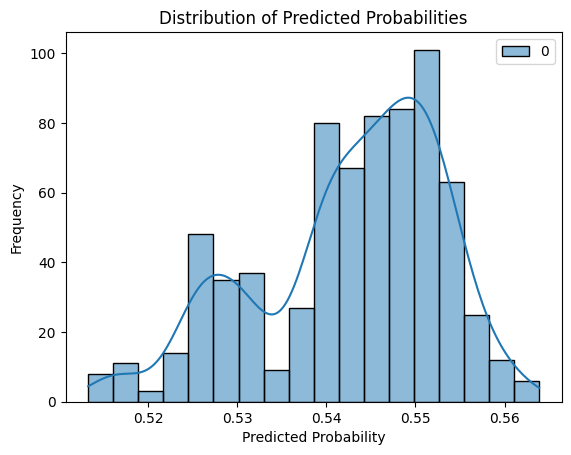

In [ ]:
y_pred = tuned_lstm_backup.predict(X_test_reshaped)
# This shows that the model is rather unconfident with its predictions:
# small standard deviation around 0.5 probability (i.e. guessing)
sns.histplot(y_pred, kde=True, color='blue', alpha=0.5)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

## ARIMA
We consider a shorter timeframe for our ARIMA analysis, due to the changed market environment for BTC in our initial timeframe. Since ARIMA is dependent on continous data, this is likely to disturb the model.

### Time-series exploration

In [ ]:
# 'Transform' data into a timeseries
time_series = data_final.set_index('Date')
target = time_series['Close']
# Chose selected_features (from RandomForrestClassifier), reducing complexity
time_series = time_series.iloc[:, selected_features]

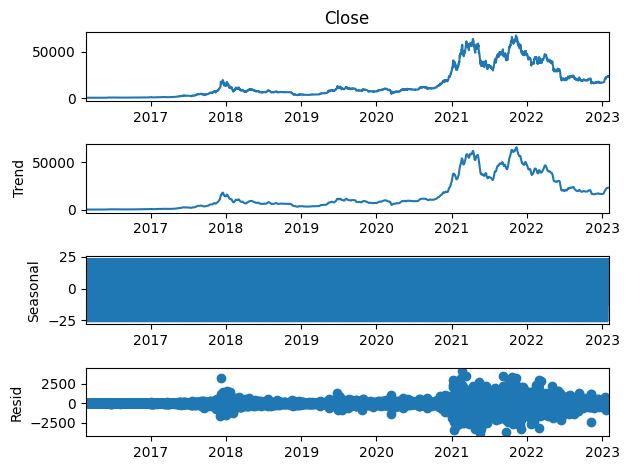

In [ ]:
result_add = seasonal_decompose(target, model='additive')
result_add.plot();

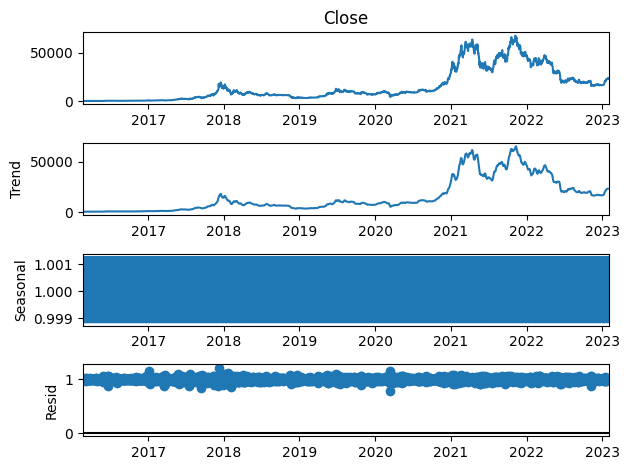

In [ ]:
result_mul = seasonal_decompose(target, model='multiplicative' )
result_mul.plot();

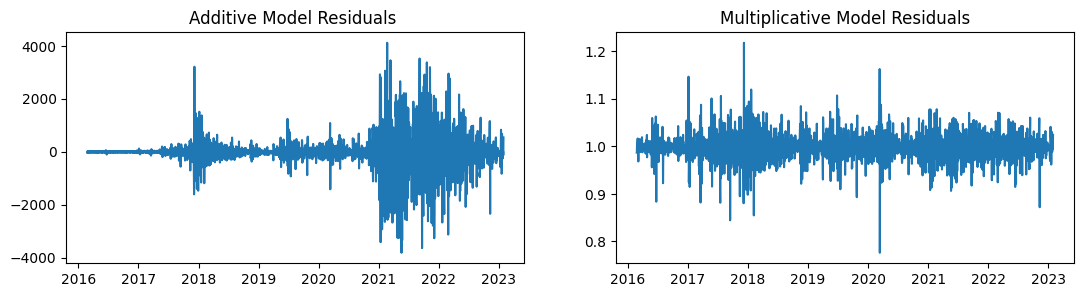

In [ ]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add.resid); ax1.set_title("Additive Model Residuals ")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative Model Residuals");

In [ ]:
print('p-value:', adfuller(target)[1])
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multiplicative resid: ', adfuller(result_mul.resid.dropna())[1])

p-value: 0.4751980882095462
additive resid:  2.2120893123718796e-30
multiplicative resid:  3.471432526872055e-29


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



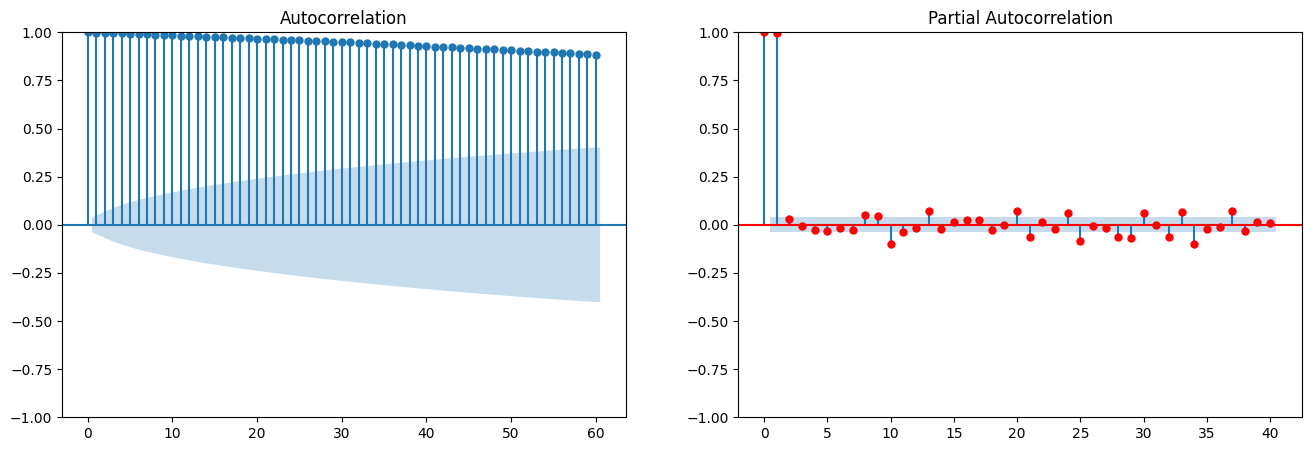

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,5))
plot_acf(target, lags=60, ax=axes[0]);
plot_pacf(target, lags=40, ax=axes[1], color='r');

**General explanation**
*Typically we will have a general decline in correlation between a specific time and a day further in the past; the further back in time you look, the less likely it is that that shift will have an influence.*

**ACF (left): correlation of series with itself**
*   slow exponential decrease
*   if X(t) is always correlated with X(t ! 1), then it is also correlated with X(t ! 2)

**PACF (right)**
removes intermediary correlations


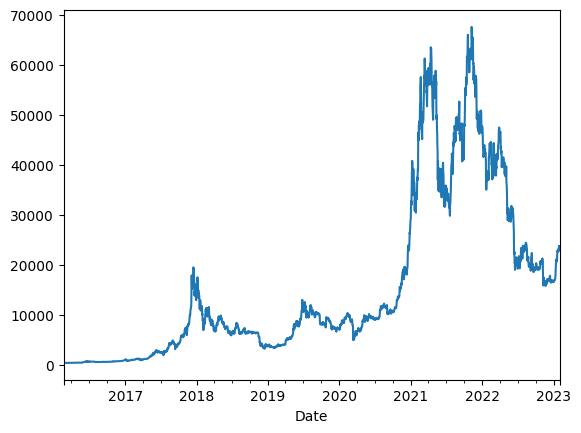

In [ ]:
# No seasonlaity can be observed
target.plot();

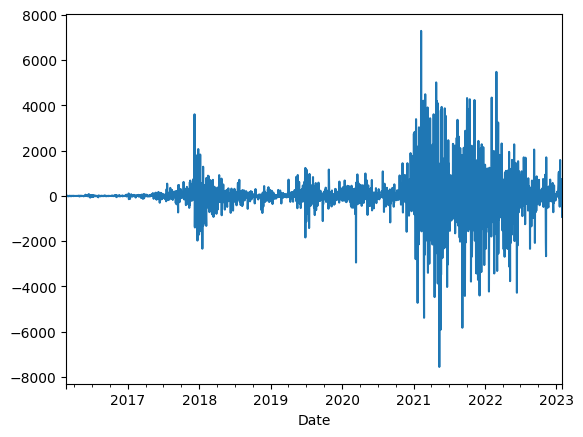

In [ ]:
# Making data stationary (requirement for ARIMA)
target.diff().plot();

In [ ]:
# Determine impact of stationarity
print('p-value zero-diff: ', adfuller(target)[1])
print('p-value first-diff: ', adfuller(target.diff().dropna())[1])
print('p-value second-diff: ', adfuller(target.diff().diff().dropna())[1])

# How many difs are needed for stationatrity (with module)?
ndiffs(target)

p-value zero-diff:  0.4751980882095462
p-value first-diff:  1.9621359636871807e-12
p-value second-diff:  2.029368940958834e-30


1

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



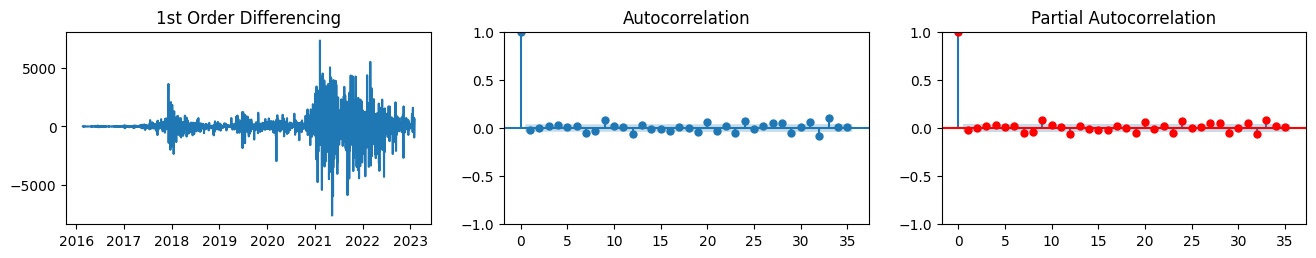

In [ ]:
# Applying differentiation for stationarity
target_diff = target.diff().dropna()

# Plotting impact
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(target_diff); axes[0].set_title('1st Order Differencing')
plot_acf(target_diff, ax=axes[1]);
plot_pacf(target_diff, ax=axes[2], c='r');

In [ ]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(target, test_size=test_size, shuffle=False)

### Auto ARIMA for parameter identification

In [ ]:
# Fit an AutoARIMA model with hyperparameter tuning
model = auto_arima(
    train_data,
    max_p=5,
    max_q=5,
    max_d=5,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    seasonal=True,
    max_order=None,
    out_of_sample_size=1,
    scoring='mse'
)

# Print the summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25790.869, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25786.790, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25786.604, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25786.623, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25788.645, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=25788.600, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25788.615, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25790.608, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=25788.192, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.883 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1776
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -12890.302
Date:                Fri, 05 May 2023   

### Model with and without exogenous variables

In [ ]:
# ARIMA needs index for everyday
idx = pd.date_range(start=time_series.index.min(), end=time_series.index.max(), freq='D')
# Use reindex to fill in missing dates with np.nan
time_series = time_series.reindex(idx, fill_value=np.nan)
target = target.reindex(idx, fill_value=np.nan)

#### Predicting

In [ ]:
# Separate training from testing
window_size = int(len(time_series) * (1 - test_size))

# Initialize an empty list to store the predictions
predictions = {'ts_only': [], 'exog': []}

# Predict one price at a time, starting from after first training window
for i in range(window_size, len(time_series)):
    
    # Extract train window
    ts = target.iloc[i-window_size:i]
    # ARIMA with time_series only (no exogenous variables)
    arima_ts = ARIMA(ts, order=(1,1,0), freq='D', missing='drop')
    arima_ts = arima_ts.fit()
    # Make a one-step-ahead forecast for the next observation
    y_pred_ts = arima_ts.forecast()[0]
    # Append the predicted value to the list of predictions
    predictions['ts_only'].append(y_pred_ts)

    # Extract train window
    exog = time_series.iloc[i-window_size:i]
    # Scale exog variables
    scaler = MinMaxScaler()
    exog_scaled = scaler.fit_transform(exog)
    # Fit an ARIMA model to the training data
    arima_exog = ARIMA(ts, exog=exog_scaled, order=(1,1,0), freq='D', missing='drop')
    arima_exog = arima_exog.fit()
    # Make a one-step-ahead forecast for the next observation
    y_pred_exog = arima_exog.predict(exog=exog.iloc[-1])[0]
    # Append the predicted value to the list of predictions
    predictions['exog'].append(y_pred_exog)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3

#### Performance

In [ ]:
# Calculate the mean squared error of the predictions
mse_ts = mean_absolute_percentage_error(target[window_size:], np.array(predictions['ts_only']))
mse_exog = mean_absolute_percentage_error(target[window_size:], np.array(predictions['exog']))

# Print the mean squared error
print(
    'MAPE ts only:', mse_ts,
    '\nMAPE ts and exog:', mse_exog,
)

MAPE ts only: 0.026446770849581993 
MAPE ts and exog: 0.9102547794897982


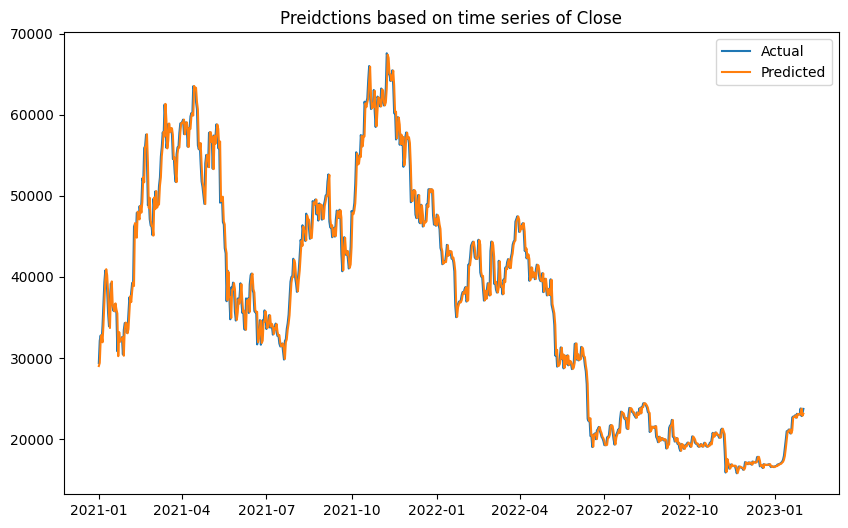

In [ ]:
# Plot y_test against y_pred
y_pred_ts = pd.Series(predictions['ts_only'], index=time_series[window_size:].index)

# Plot y_test and y_pred_ts on the same figure
plt.figure(figsize=(10, 6))
plt.plot(target[window_size:], label='Actual')
plt.plot(y_pred_ts, label='Predicted')
plt.title('Preidctions based on time series of Close')
plt.legend()
plt.show()

In [ ]:
# Plot y_test against y_pred_exog
y_pred_exog = pd.Series(predictions['exog'], index=time_series[window_size:].index)

# Plot y_test and y_pred_exog on the same figure
plt.figure(figsize=(10, 6))
plt.plot(target[window_size:], label='Actual')
plt.plot(y_pred_exog, label='Predicted')
plt.title('Preidctions based on time series of Close and exogenous variables')
plt.legend()
plt.show()

**NOTE** ARIMA predicts the price on the next day, given data of the past. Because ARIMA is not adequate for classification problems (binary outcome), we have to translate the price prediction it made to make. This enables us to compare the accuracy of the ARIMA model to our LSTM.

In [ ]:
# Access relevant test data set
test_df = data_final.iloc[-len(y_pred_ts):].copy()

# Set signal where the predicted price of tomorow (model output) is higher than today
test_df['signal_ts'] = np.where(
    y_pred_ts.values > test_df['Close'].values,
    1,
    0
)
# ... do same for predictions with exogenous variables
test_df['signal_exog'] = np.where(
    y_pred_exog.values > test_df['Close'].values,
    1,
    0
)

# Compare actuals actuals vs predictions to evaluate accuracy
print(
    '(Artificial) accuracy scoring:'
    '\nts only:', accuracy_score(test_df['next_day_up'], test_df['signal_ts']),
    '\nwith exog:', accuracy_score(test_df['next_day_up'], test_df['signal_exog'])
)

(Artificial) accuracy scoring:
ts only: 0.5328083989501312 
with exog: 0.5039370078740157


# Trading

## Based on LSTM predictions

23/23 [==============================] - 0s 18ms/step
prediction period: 712


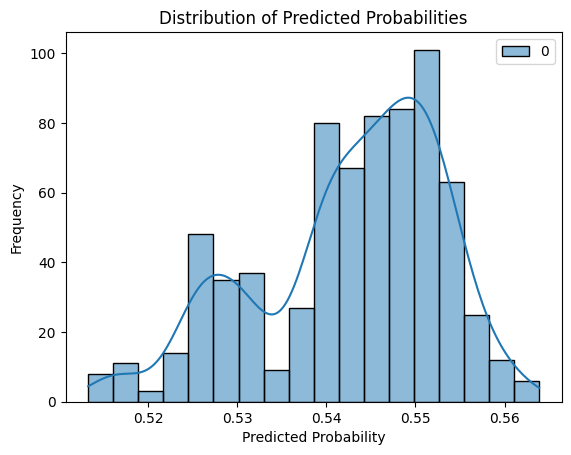

In [ ]:
y_pred = tuned_lstm_backup.predict(X_test_reshaped)
print('prediction period:', len(y_pred))

# Investigate predictions made visually
sns.histplot(y_pred, kde=True, color='blue', alpha=0.5)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

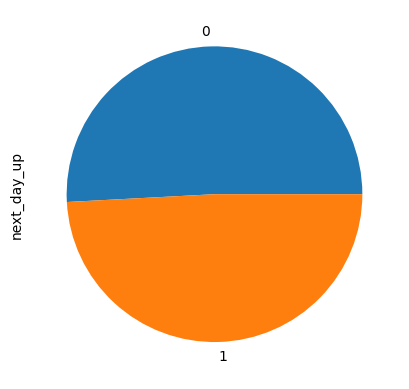

In [ ]:
test_df = data_final.iloc[-len(y_pred):].copy()
test_df['next_day_up'].value_counts().plot(kind='pie')
plt.show()

**Observations**
* This shows that the model cannot predict the outcome very confidently. The predictions have a small deviation around 0.5. A prediction of 0.5 is the equivalent of guessing
* Comparing the predictions with the visual inspections of our target variable, we see that the general distribution is not correct: our test set has more 0s than 1, but the model's general prediction is above 0.5

### Strategy 1

In [ ]:
verbose = 0

# Strategy 1) invest all available capital if threshold is met

# Thresholds should be evenly distributed between the min and max
thresholds = np.linspace(y_pred.min(), y_pred.max(), num=10).tolist()
for threshold in thresholds:

  test_df['y_pred'] = y_pred
  # Set signal based on threshold
  test_df['signal'] = np.where(
      y_pred >= threshold, 1, 0
  )

  print('\n### threshold:', threshold, '###')

  capital = 1_000

  total_profit = 0
  n_coins = 0
  n_trades = 0

  for ix, row in test_df.iterrows():

    if verbose>1:
      print('\n### Trading day:', row['Date'], 'signal:', row['signal'], '###')
    
    # Invest all capital available
    if row['signal'] == 1 and capital > 0:

      # Buy as much coins as possible
      n_coins = capital / row['Close']
      capital_invested = np.round(n_coins * row['Close'], 2)
      capital = 0

      if verbose>0:
        print(
            '\n#### COINS Bought ####',
            '\nTrade exdcuted:', capital_invested, 'invested in', n_coins, 'coins at', row['Close']
        )
     
      n_trades += 1

    # Sell all coins, if sell signal or last trading day
    elif (row['signal'] == 0 or row['Date'] == test_df['Date'].max()) and n_coins > 0 :

      # Sell all available coins
      trade_revenue = np.round(n_coins * row['Close'], 2)
      n_coins = 0
      trade_profit = np.round(trade_revenue - capital_invested, 2)

      # Revenue gets reinvested
      capital = trade_revenue

      # trade_profit added to total profit
      total_profit += trade_profit

      if verbose>0:
        print(
            '\n#### COINS SOLD ####',
            '\nProfit of trade:', trade_profit,
            '\nTotal profit:', total_profit,
            '\nCapital available:', capital
        )

  print(
      'trades made:', n_trades,
      '\nprofit made:', np.round(total_profit, 2)
  )


### threshold: 0.513275146484375 ###
trades made: 1 
profit made: -577.11

### threshold: 0.5188970234658983 ###
trades made: 2 
profit made: -645.1

### threshold: 0.5245189004474216 ###
trades made: 10 
profit made: -637.89

### threshold: 0.5301407774289449 ###
trades made: 11 
profit made: -534.34

### threshold: 0.5357626544104682 ###
trades made: 5 
profit made: -565.46

### threshold: 0.5413845313919915 ###
trades made: 14 
profit made: -581.07

### threshold: 0.5470064083735148 ###
trades made: 19 
profit made: 13.85

### threshold: 0.5526282853550382 ###
trades made: 17 
profit made: 103.68

### threshold: 0.5582501623365614 ###
trades made: 4 
profit made: 176.99

### threshold: 0.5638720393180847 ###
trades made: 1 
profit made: 6.3


### Strategy 2

In [ ]:
verbose = 0

# Strategy 2) invest x% of available capital if threshold is met

# Thresholds should be evenly distributed between the min and max
thresholds = np.linspace(y_pred.min(), y_pred.max(), num=10).tolist()
for threshold in thresholds:

  test_df['y_pred'] = y_pred
  # Set signal based on threshold
  test_df['signal'] = np.where(
      y_pred >= threshold, 1, 0
  )

  print('\n### threshold:', threshold, '###')

  capital = 1_000
  capital_invested = 0
  # Determines share of capital invested per trade
  risk_appetite = .5

  total_profit = 0
  n_coins = 0
  n_trades = 0

  for ix, row in test_df.iterrows():

    if verbose>1:
      print('\n### Trading day:', row['Date'], 'signal:', row['signal'], '###')
    
    # Invest all capital available
    if row['signal'] == 1 and capital > 0:

      # Invest x% of capital
      coins_bought = (capital * risk_appetite) / row['Close']
      capital_invested += np.round(coins_bought * row['Close'], 2)
      n_coins += coins_bought
      capital -= capital_invested

      if verbose>0:
        print(
            '\n#### COINS BOUGHT ####',
            '\n', capital_invested, 'currently invested in', n_coins
        )
     
      n_trades += 1

    # Sell all coins, if sell signal or last trading day
    elif (row['signal'] == 0 or row['Date'] == test_df['Date'].max()) and n_coins > 0 :

      # Sell all available coins
      trade_revenue = np.round(n_coins * row['Close'], 2)
      n_coins = 0
      trade_profit = np.round(trade_revenue - capital_invested, 2)
      capital_invested = 0

      # Revenue gets reinvested
      capital += trade_revenue

      # trade_profit added to total profit
      total_profit += trade_profit

      if verbose>0:
        print(
            '\n#### COINS SOLD ####',
            '\nProfit of trade:', trade_profit,
            '\nTotal profit:', total_profit,
            '\nCapital available:', capital
        )

  print(
      'trades made:', n_trades,
      '\nprofit made:', np.round(total_profit, 2)
  )


### threshold: 0.513275146484375 ###
trades made: 2 
profit made: -435.48

### threshold: 0.5188970234658983 ###
trades made: 3 
profit made: -486.05

### threshold: 0.5245189004474216 ###
trades made: 18 
profit made: -282.04

### threshold: 0.5301407774289449 ###
trades made: 20 
profit made: -230.15

### threshold: 0.5357626544104682 ###
trades made: 10 
profit made: -163.05

### threshold: 0.5413845313919915 ###
trades made: 24 
profit made: -152.27

### threshold: 0.5470064083735148 ###
trades made: 34 
profit made: 136.61

### threshold: 0.5526282853550382 ###
trades made: 31 
profit made: 68.72

### threshold: 0.5582501623365614 ###
trades made: 8 
profit made: 103.1

### threshold: 0.5638720393180847 ###
trades made: 1 
profit made: 3.15


## Based on ARIMA
**NOTE** This model predicts the price, instead of a probability of the price going up the next day, which is a classification problem. Classification problems are not suitable for an ARIMA model

### Time-series only

In [ ]:
# Access predictions from ARIMA model
y_pred = predictions['ts_only']
# Access relevant test data
test_df = data_final.iloc[-len(y_pred):].copy()

# Prediction is on next day's Close
test_df['price_next_day'] = y_pred
# Signal if prediction for tomorow is higher than today
test_df['signal'] = np.where(
    test_df['price_next_day'] > test_df['Close'],
    1,
    0
)

#### Strategy 1

In [ ]:
verbose = 0

# Strategy 1) invest all available capital if threshold is met

capital = 1_000

total_profit = 0
n_coins = 0
n_trades = 0

for ix, row in test_df.iterrows():

  if verbose>1:
    print('\n### Trading day:', row['Date'], 'signal:', row['signal'], '###')
  
  # Invest all capital available
  if row['signal'] == 1 and capital > 0:

    # Buy as much coins as possible
    n_coins = capital / row['Close']
    capital_invested = np.round(n_coins * row['Close'], 2)
    capital = 0

    if verbose>0:
      print(
          '\n#### COINS Bought ####',
          '\nTrade exdcuted:', capital_invested, 'invested in', n_coins, 'coins at', row['Close']
      )
    
    n_trades += 1

  # Sell all coins, if sell signal or last trading day
  elif (row['signal'] == 0 or row['Date'] == test_df['Date'].max()) and n_coins > 0 :

    # Sell all available coins
    trade_revenue = np.round(n_coins * row['Close'], 2)
    n_coins = 0
    trade_profit = np.round(trade_revenue - capital_invested, 2)

    # Revenue gets reinvested
    capital = trade_revenue

    # trade_profit added to total profit
    total_profit += trade_profit

    if verbose>0:
      print(
          '\n#### COINS SOLD ####',
          '\nProfit of trade:', trade_profit,
          '\nTotal profit:', total_profit,
          '\nCapital available:', capital
      )

print(
    'trades made:', n_trades,
    '\nprofit made:', np.round(total_profit, 2)
)

trades made: 201 
profit made: 358.82


#### Strategy 2

In [ ]:
verbose = 0

# Strategy 2) invest x% of available capital if threshold is met

capital = 1_000
capital_invested = 0
# Determines share of capital invested per trade
risk_appetite = .5

total_profit = 0
n_coins = 0
n_trades = 0

for ix, row in test_df.iterrows():

  if verbose>1:
    print('\n### Trading day:', row['Date'], 'signal:', row['signal'], '###')
  
  # Invest all capital available
  if row['signal'] == 1 and capital > 0:

    # Invest x% of capital
    coins_bought = (capital * risk_appetite) / row['Close']
    capital_invested += np.round(coins_bought * row['Close'], 2)
    n_coins += coins_bought
    capital -= capital_invested

    if verbose>0:
      print(
          '\n#### COINS BOUGHT ####',
          '\n', capital_invested, 'currently invested in', n_coins
      )
    
    n_trades += 1

  # Sell all coins, if sell signal or last trading day
  elif (row['signal'] == 0 or row['Date'] == test_df['Date'].max()) and n_coins > 0 :

    # Sell all available coins
    trade_revenue = np.round(n_coins * row['Close'], 2)
    n_coins = 0
    trade_profit = np.round(trade_revenue - capital_invested, 2)
    capital_invested = 0

    # Revenue gets reinvested
    capital += trade_revenue

    # trade_profit added to total profit
    total_profit += trade_profit

    if verbose>0:
      print(
          '\n#### COINS SOLD ####',
          '\nProfit of trade:', trade_profit,
          '\nTotal profit:', total_profit,
          '\nCapital available:', capital
      )

print(
    'trades made:', n_trades,
    '\nprofit made:', np.round(total_profit, 2)
)

trades made: 303 
profit made: -12.09


### With exogenous variables

In [ ]:
# Access predictions from ARIMA model
y_pred = predictions['exog']
# Access relevant test data
test_df = data_final.iloc[-len(y_pred):].copy()

# Prediction is on next day's Close
test_df['price_next_day'] = y_pred
# Signal if prediction for tomorow is higher than today
test_df['signal'] = np.where(
    test_df['price_next_day'] > test_df['Close'],
    1,
    0
)

#### Strategy 1

In [ ]:
verbose = 0

# Strategy 1) invest all available capital if threshold is met

capital = 1_000

total_profit = 0
n_coins = 0
n_trades = 0

for ix, row in test_df.iterrows():

  if verbose>1:
    print('\n### Trading day:', row['Date'], 'signal:', row['signal'], '###')
  
  # Invest all capital available
  if row['signal'] == 1 and capital > 0:

    # Buy as much coins as possible
    n_coins = capital / row['Close']
    capital_invested = np.round(n_coins * row['Close'], 2)
    capital = 0

    if verbose>0:
      print(
          '\n#### COINS Bought ####',
          '\nTrade exdcuted:', capital_invested, 'invested in', n_coins, 'coins at', row['Close']
      )
    
    n_trades += 1

  # Sell all coins, if sell signal or last trading day
  elif (row['signal'] == 0 or row['Date'] == test_df['Date'].max()) and n_coins > 0 :

    # Sell all available coins
    trade_revenue = np.round(n_coins * row['Close'], 2)
    n_coins = 0
    trade_profit = np.round(trade_revenue - capital_invested, 2)

    # Revenue gets reinvested
    capital = trade_revenue

    # trade_profit added to total profit
    total_profit += trade_profit

    if verbose>0:
      print(
          '\n#### COINS SOLD ####',
          '\nProfit of trade:', trade_profit,
          '\nTotal profit:', total_profit,
          '\nCapital available:', capital
      )

print(
    'trades made:', n_trades,
    '\nprofit made:', np.round(total_profit, 2)
)

trades made: 0 
profit made: 0


#### Strategy 2

In [ ]:
verbose = 0

# Strategy 2) invest x% of available capital if threshold is met

capital = 1_000
capital_invested = 0
# Determines share of capital invested per trade
risk_appetite = .5

total_profit = 0
n_coins = 0
n_trades = 0

for ix, row in test_df.iterrows():

  if verbose>1:
    print('\n### Trading day:', row['Date'], 'signal:', row['signal'], '###')
  
  # Invest all capital available
  if row['signal'] == 1 and capital > 0:

    # Invest x% of capital
    coins_bought = (capital * risk_appetite) / row['Close']
    capital_invested += np.round(coins_bought * row['Close'], 2)
    n_coins += coins_bought
    capital -= capital_invested

    if verbose>0:
      print(
          '\n#### COINS BOUGHT ####',
          '\n', capital_invested, 'currently invested in', n_coins
      )
    
    n_trades += 1

  # Sell all coins, if sell signal or last trading day
  elif (row['signal'] == 0 or row['Date'] == test_df['Date'].max()) and n_coins > 0 :

    # Sell all available coins
    trade_revenue = np.round(n_coins * row['Close'], 2)
    n_coins = 0
    trade_profit = np.round(trade_revenue - capital_invested, 2)
    capital_invested = 0

    # Revenue gets reinvested
    capital += trade_revenue

    # trade_profit added to total profit
    total_profit += trade_profit

    if verbose>0:
      print(
          '\n#### COINS SOLD ####',
          '\nProfit of trade:', trade_profit,
          '\nTotal profit:', total_profit,
          '\nCapital available:', capital
      )

print(
    'trades made:', n_trades,
    '\nprofit made:', np.round(total_profit, 2)
)

trades made: 0 
profit made: 0
